# Manual Analysis Results
Pulls in the results of manual analysis and computes chemotaxis index and number of worms.

In [1]:
import time
start = time.time()
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
# import scipy.stats as stats
# from scipy import ndimage as ndi
import numpy as np
import pathlib
import warnings
import seaborn as sns
import pydrive


### Load the data from manual analysis

In [2]:
base_folder = pathlib.Path('/Users/adam/Documents/Neuroplant/')
data_folder = base_folder.joinpath('Manual_analysis_results')
metadata = pd.read_csv(base_folder.joinpath(
    'Neuroplant Image Analysis (Responses) - Form Responses 1.csv'))

metadata.rename(columns={'Plate ID (Example: NPP001)': 'plate_id',
                         'Well ID (P,Q,R, or S):': 'well_id',
                         "Image Analyzer's Name:": 'user',
                         'In your best estimation does it appear that the worms were repelled by, attracted to or indifferent to the compound? (Compound:Right, Solvent:Left)': 'user_impression',
                        'Additional Notes:': 'notes'}, inplace=True)

assay_metadata = pd.read_csv(base_folder.joinpath(
    'Neuroplant Chemotaxis Assay Responses - Form Responses 1.csv'))
assay_metadata.rename(columns={'Plate ID (example NPP001):': 'plate_id',
                               'CompoundDecode': 'compound',
                               'Decode in Well P:': 'well_P_strain',
                               'Decode in Well Q:': 'well_Q_strain',
                               'Decode in Well R:': 'well_R_strain',
                               'Decode in Well S:': 'well_S_strain'}, inplace=True)


In [3]:
results_files = data_folder.glob('*.csv')

manual_analysis_results = []
for file in results_files:
    this_experiment_df = pd.read_csv(file, index_col=' ')
    plate_id = file.stem[0:6]
    this_experiment_df['plate_id'] = plate_id
    well_id = file.stem[-1].upper()
    this_experiment_df['well_id'] = well_id
    user = file.stem.split('_')[1]
    this_experiment_df['user'] = user
    this_experiment_metadata = metadata.loc[
        (metadata['plate_id'] == plate_id) &
        (metadata['well_id'] == well_id) &
        (metadata["user"] == user)]
    
    # check for correct metadata size
    if this_experiment_metadata.shape == (1, 8):
        this_experiment_df['email'] = this_experiment_metadata['Email Address'].values[0]
        this_experiment_df['timestamp'] = this_experiment_metadata['Timestamp'].values[0]
        this_experiment_df['image_filename'] = this_experiment_metadata['Image Filename :'].values[0]
        this_experiment_df['user_impression'] = this_experiment_metadata[
            'user_impression'].values[0]
        this_experiment_df['user_impression'] = this_experiment_df['user_impression'].astype('category')
        this_experiment_df['notes'] = this_experiment_metadata['notes']
        manual_analysis_results.append(this_experiment_df)
    else:
        print(this_experiment_metadata)
        warnings.warn('Metadata not paired with data properly for ' + str(file))
        metadata.drop(labels=this_experiment_metadata.index, axis='index', inplace=True,)

#         display(this_experiment_metadata)
#         print(plate_id, user, well_id, str(file.stem), this_experiment_metadata.shape)
manual_analysis_results = pd.concat(manual_analysis_results)

/miniconda2/envs/neuroplant/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Metadata not paired with data properly for /Users/adam/Documents/Neuroplant/Manual_analysis_results/NPP006_Lingxin_Q.csv
/miniconda2/envs/neuroplant/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Metadata not paired with data properly for /Users/adam/Documents/Neuroplant/Manual_analysis_results/NPP016_Jason_S.csv
/miniconda2/envs/neuroplant/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Metadata not paired with data properly for /Users/adam/Documents/Neuroplant/Manual_analysis_results/NPP029_Tom_Q.csv
/miniconda2/envs/neuroplant/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Metadata not paired with data properly for /Users/adam/Documents/Neuroplant/Manual_analysis_results/NPP030_Tom_P.csv
/miniconda2/envs/neuroplant/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Sorting because non-concatenation axis is not ali

### Calculate chemotaxis index

In [5]:
solvent_limit = int(21000*2/5) #8000
compount_limit = int(21000*3/5) #13000


for index, well in metadata.iterrows():
    plate_id = well['plate_id']
    well_id = well['well_id']
    compound_side_worms = manual_analysis_results.loc[
            (manual_analysis_results['plate_id'] == plate_id) &
            (manual_analysis_results['well_id'] == well_id) &
            (manual_analysis_results['X'] >= compount_limit)].shape[0]
    metadata.loc[index, 'worms_on_compound_side'] = compound_side_worms
    
    solvent_side_worms = manual_analysis_results.loc[
            (manual_analysis_results['plate_id'] == plate_id) &
            (manual_analysis_results['well_id'] == well_id) &
            (manual_analysis_results['X'] <= solvent_limit)].shape[0]
    metadata.loc[index, 'worms_on_solvent_side'] = solvent_side_worms
    
    neutral_worms = manual_analysis_results.loc[
            (manual_analysis_results['plate_id'] == plate_id) &
            (manual_analysis_results['well_id'] == well_id) &
            (manual_analysis_results['X'] >= solvent_limit) &
            (manual_analysis_results['X'] <= compount_limit)].shape[0]
    metadata.loc[index, 'worms_on_neutral_side'] = neutral_worms
    try:
        metadata.loc[index, 'chemotaxis_index'] = ((compound_side_worms - solvent_side_worms) / 
                                                   (compound_side_worms + solvent_side_worms))
        metadata.loc[index, 'centroid_x'] = manual_analysis_results.loc[
            (manual_analysis_results['plate_id'] == plate_id) &
            (manual_analysis_results['well_id'] == well_id)]['X'].mean()
        metadata.loc[index, 'centroid_y'] = manual_analysis_results.loc[
            (manual_analysis_results['plate_id'] == plate_id) &
            (manual_analysis_results['well_id'] == well_id)]['Y'].mean()
    except ZeroDivisionError:
        pass
#         print(well)

In [6]:
def translate_impression_to_number(row):
    if row['user_impression'] == 'Repelled':
        faux_index = -0.5
    elif row['user_impression'] == 'Indifferent':
        faux_index = 0
    elif row['user_impression'] == 'Attracted':
        faux_index = 0.5
    else:
        warnings.warn('Failed to recognize user impression')
    
    return faux_index

metadata['impression_index'] = metadata.apply(lambda row: translate_impression_to_number(row), axis=1)

In [7]:
# metadata[['plate_id', 'well_id', 'user_impression', 'chemotaxis_index', 'impression_index']]

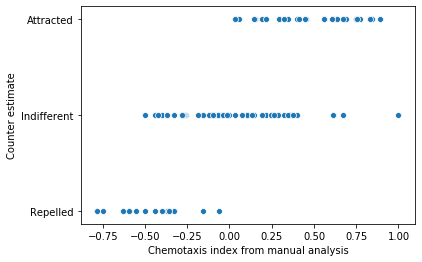

In [8]:
ax = sns.scatterplot(x='chemotaxis_index', y='impression_index', data=metadata)
ax.set_xlabel('Chemotaxis index from manual analysis')
ax.set_ylabel('Counter estimate')
ax.set_yticks([-0.5, 0, 0.5])
ax.set_yticklabels(['Repelled', 'Indifferent', 'Attracted']);

### Plot EVERYTHING

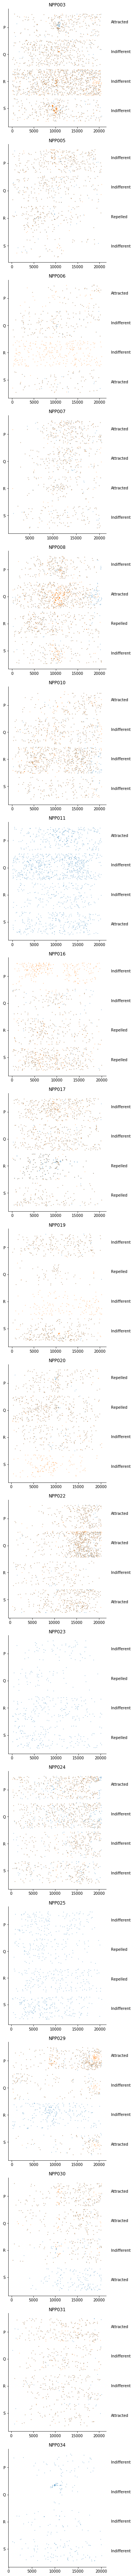

In [9]:
n_plates = len(manual_analysis_results['plate_id'].unique())
fig, axes = plt.subplots(nrows=n_plates, ncols=2, figsize=(5, 5 * n_plates),
                         constrained_layout=True, gridspec_kw={'width_ratios':[4,1]})

index = 0
# all_plates_with_some_analysis = [manual_analysis_results['plate_id'].unique()
for plate in manual_analysis_results['plate_id'].unique():
    sns.scatterplot(x='X', y='Y', hue='user', style='plate_id', legend=None, ax=axes[index, 0],
                    linewidth=0, alpha=0.5, s=3,
                    data=manual_analysis_results.loc[manual_analysis_results['plate_id'] == plate])
    
    try:
        automated_results_list = []
        for well_id in ['P', 'Q', 'R', 'S']:
            automated_results = pd.read_csv(data_folder.parent.joinpath(
                'automated_analysis_results', plate + '_automatedAnalyzer_' + well_id +'.csv'))
            automated_results['plate_id'] = plate
            automated_results['well_id'] = well_id            
            automated_results_list.append(automated_results)
        automated_results = pd.concat(automated_results_list)
        sns.scatterplot(x='X', y='Y', legend=None, ax=axes[index, 0],
                        linewidth=0, alpha=0.5, s=3, color=sns.color_palette()[2],
                        data=automated_results.loc[automated_results['plate_id'] == plate])
    except FileNotFoundError:
        pass
    
    sns.despine()
#     axes[index, 0].set_xticks([0, 20000])
#     axes[index, 0].set_xticklabels(['Solvent', 'Compound'])
    axes[index, 0].get_xaxis().get_label().set_visible(False)
    
    axes[index, 0].set_yticks(list(range(int(30000/8), 30000, int(30000/4))))
    axes[index, 0].set_yticklabels(['P', 'Q', 'R', 'S'])
    axes[index, 0].get_yaxis().get_label().set_visible(False)
    
    axes[index, 0].invert_yaxis()
    axes[index, 0].set_title(plate)
    
    axes[index, 1].text(
        x=0, y=0,
        s=manual_analysis_results.loc[
            (manual_analysis_results['plate_id'] == plate) &
            (manual_analysis_results['well_id'] == 'P')][
            'user_impression'].values[0])
    axes[index, 1].text(
        x=0, y=1,
        s=manual_analysis_results.loc[
            (manual_analysis_results['plate_id'] == plate) &
            (manual_analysis_results['well_id'] == 'Q')][
            'user_impression'].values[0])
    axes[index, 1].text(
        x=0, y=2,
        s=manual_analysis_results.loc[
            (manual_analysis_results['plate_id'] == plate) &
            (manual_analysis_results['well_id'] == 'R')][
            'user_impression'].values[0])
    axes[index, 1].text(
        x=0, y=3,
        s=manual_analysis_results.loc[
            (manual_analysis_results['plate_id'] == plate) &
            (manual_analysis_results['well_id'] == 'S')][
            'user_impression'].values[0])
    axes[index, 1].set_ylim(-0.5, 3.5)
    axes[index, 1].axis('off')

    index += 1

fig.savefig(base_folder.joinpath('manual_analysis_results.pdf'))

In [46]:
automated_results_file = data_folder.parent.joinpath('chemotaxis_summary.csv')
automated_analysis_results = pd.read_csv(automated_results_file)
automated_analysis_results.rename(columns={'Plate_id': 'plate_id',
                                           'Well_id': 'well_id'}, inplace=True)
def add_strain(row, assay_metadata):
       
    strain = assay_metadata.loc[
        assay_metadata['plate_id']==row['plate_id']][
        'well_'+row['well_id']+'_strain']
    return strain.values[0]

def add_compound(row, assay_metadata):
    compound = assay_metadata.loc[
        assay_metadata['plate_id']==row['plate_id']]['compound']
    return compound.values[0]

automated_analysis_results['strain'] = automated_analysis_results.apply(
    lambda row: add_strain(row, assay_metadata), axis=1).astype('category')
automated_analysis_results['compound'] = automated_analysis_results.apply(
    lambda row: add_compound(row, assay_metadata), axis=1).astype('category')
automated_analysis_results['analysis_method'] = 'automated'

automated_analysis_results.columns

Index(['Unnamed: 0', 'plate_id', 'well_id', 'results_file', 'chemotaxis_index',
       'centroid_x', 'centroid_y', 'strain', 'compound', 'analysis_method'],
      dtype='object')

In [47]:
metadata['strain'] = metadata.apply(
    lambda row: add_strain(row, assay_metadata), axis=1).astype('category')
metadata['compound'] = metadata.apply(
    lambda row: add_compound(row, assay_metadata), axis=1).astype('category')
metadata['analysis_method'] = 'manual'

In [48]:
metadata.columns

Index(['Timestamp', 'Email Address', 'user', 'Image Filename :', 'plate_id',
       'well_id', 'user_impression', 'notes', 'worms_on_compound_side',
       'worms_on_solvent_side', 'worms_on_neutral_side', 'chemotaxis_index',
       'centroid_x', 'centroid_y', 'impression_index', 'strain', 'compound',
       'analysis_method'],
      dtype='object')

In [49]:
combined_results = pd.concat([metadata[['plate_id',
                                       'well_id',
                                       'chemotaxis_index',
                                       'strain',
                                       'compound',
                                       'analysis_method']].copy(),
                             automated_analysis_results[['plate_id',
                                                         'well_id',
                                                         'chemotaxis_index',
                                                         'strain', 
                                                         'compound',
                                                         'analysis_method']].copy()])

,plate_id,well_id,chemotaxis_index,strain,compound,analysis_method
0,NPP023,P,-0.354331,N2,Calycanthine,manual
1,NPP023,Q,-0.259843,PR678,Calycanthine,manual
2,NPP023,R,-0.750000,CX10,Calycanthine,manual
3,NPP023,S,0.111111,PR678,Calycanthine,manual
4,NPP022,S,0.893204,CX10,Valproic acid,manual
5,NPP024,P,0.292035,CX10,Piperine,manual
6,NPP024,Q,0.610837,N2,Piperine,manual
7,NPP024,R,0.360000,PR678,Piperine,manual
8,NPP024,S,0.412781,PR678,Piperine,manual
9,NPP003,S,0.453287,CX10,trans-anethole,manual


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 <a list of 12 Text xticklabel objects>)

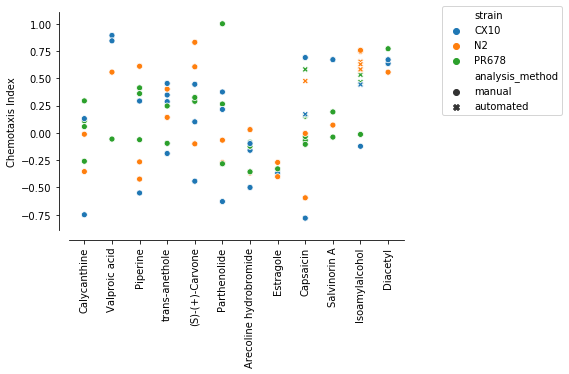

In [63]:
ax = sns.scatterplot(x='compound', y='chemotaxis_index', style='analysis_method',
                     hue='strain', data=combined_results)

ax.set_xlabel('')
ax.set_ylabel('Chemotaxis Index')
ax.legend(bbox_to_anchor=(1.1, 1.05))
sns.despine(offset=10)
plt.xticks(rotation=90)

In [45]:
combined_results

,plate_id,well_id,chemotaxis_index,strain,compound
0,NPP023,P,-0.354331,N2,Calycanthine
1,NPP023,Q,-0.259843,PR678,Calycanthine
2,NPP023,R,-0.750000,CX10,Calycanthine
3,NPP023,S,0.111111,PR678,Calycanthine
4,NPP022,S,0.893204,CX10,Valproic acid
5,NPP024,P,0.292035,CX10,Piperine
6,NPP024,Q,0.610837,N2,Piperine
7,NPP024,R,0.360000,PR678,Piperine
8,NPP024,S,0.412781,PR678,Piperine
9,NPP003,S,0.453287,CX10,trans-anethole


In [ ]:
sns.scatterplot(x='chemotaxis_index', y='centroid_x', data=automated_analysis_results)
sns.scatterplot(x='chemotaxis_index', y='centroid_x', data=metadata)

In [ ]:
print('Notebook took', str(int(time.time()-start)), 'seconds to run.')